/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


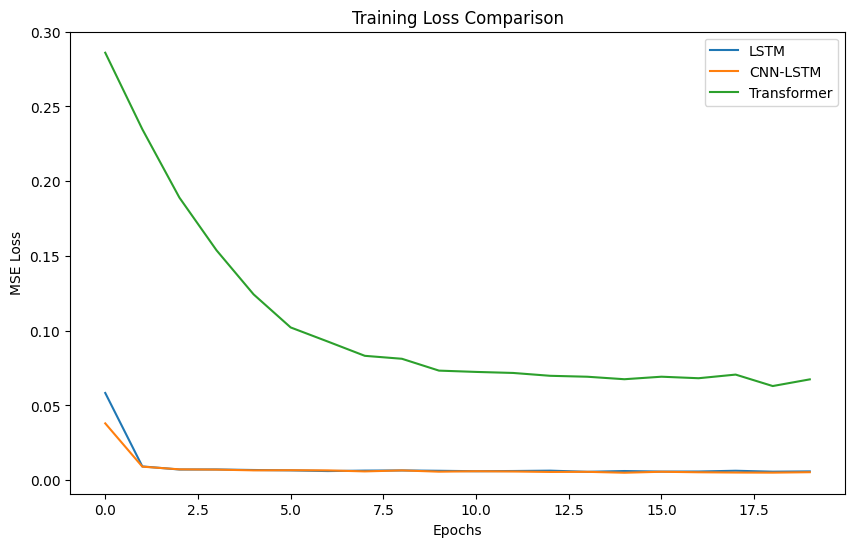

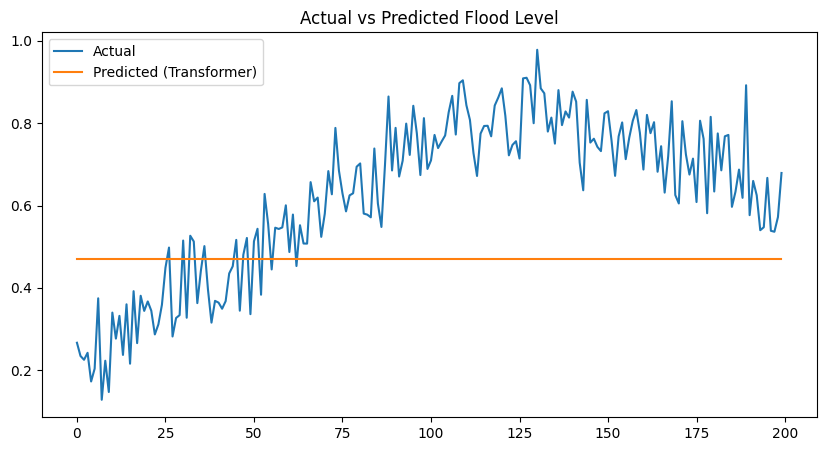

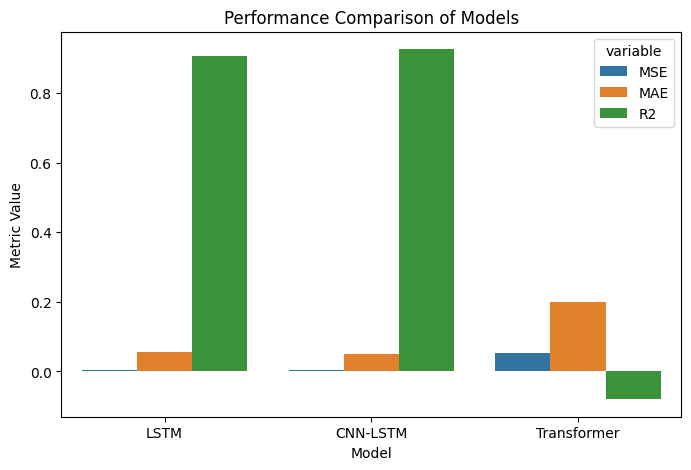

=== Model Performance Summary ===
         Model       MSE       MAE        R2
0         LSTM  0.004511  0.055134  0.906879
1     CNN-LSTM  0.003582  0.049047  0.926059
2  Transformer  0.052306  0.199106 -0.079687


In [1]:
# ===============================================
# Flood Forecasting using LSTM, CNN-LSTM, and Transformer
# ===============================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Flatten, Input
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import seaborn as sns

# -----------------------
# Create Synthetic Dataset
# -----------------------
np.random.seed(42)
days = 1500
rainfall = np.sin(np.arange(days) * 0.02) + np.random.normal(0, 0.2, days)
river_flow = np.roll(rainfall, 3) + np.random.normal(0, 0.1, days)  # simulate lagged response

data = pd.DataFrame({'Rainfall': rainfall, 'RiverFlow': river_flow})

# -----------------------
#  Preprocessing
# -----------------------
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

def create_sequences(dataset, seq_length=30):
    X, y = [], []
    for i in range(len(dataset)-seq_length):
        X.append(dataset[i:i+seq_length, 0])   # rainfall
        y.append(dataset[i+seq_length, 1])     # river flow (target)
    return np.array(X), np.array(y)

SEQ_LEN = 30
X, y = create_sequences(scaled_data, SEQ_LEN)
X = X.reshape((X.shape[0], X.shape[1], 1))

split = int(len(X)*0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

def build_lstm():
    model = Sequential([
        LSTM(64, return_sequences=False, input_shape=(SEQ_LEN,1)),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer=Adam(0.001), loss='mse')
    return model

lstm = build_lstm()
history_lstm = lstm.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=0)

def build_cnn_lstm():
    model = Sequential([
        Conv1D(64, 3, activation='relu', input_shape=(SEQ_LEN,1)),
        MaxPooling1D(2),
        LSTM(64),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer=Adam(0.001), loss='mse')
    return model

cnn_lstm = build_cnn_lstm()
history_cnn = cnn_lstm.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=0)

# -----------------------
# Transformer Model
# -----------------------
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, GlobalAveragePooling1D

def build_transformer():
    inputs = Input(shape=(SEQ_LEN,1))
    attn_output = MultiHeadAttention(num_heads=4, key_dim=32)(inputs, inputs)
    attn_output = LayerNormalization()(attn_output + inputs)
    x = GlobalAveragePooling1D()(attn_output)
    x = Dropout(0.2)(x)
    outputs = Dense(1)(x)
    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer=Adam(0.001), loss='mse')
    return model

transformer = build_transformer()
history_trans = transformer.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=0)

models = {'LSTM': lstm, 'CNN-LSTM': cnn_lstm, 'Transformer': transformer}
results = {}

for name, model in models.items():
    preds = model.predict(X_test)
    mse = mean_squared_error(y_test, preds)
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    results[name] = {'MSE': mse, 'MAE': mae, 'R2': r2, 'Predictions': preds}


# Plot 1: Training Loss comparison
plt.figure(figsize=(10,6))
plt.plot(history_lstm.history['loss'], label='LSTM')
plt.plot(history_cnn.history['loss'], label='CNN-LSTM')
plt.plot(history_trans.history['loss'], label='Transformer')
plt.title("Training Loss Comparison")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(y_test[:200], label="Actual")
plt.plot(results['Transformer']['Predictions'][:200], label="Predicted (Transformer)")
plt.title("Actual vs Predicted Flood Level")
plt.legend()
plt.show()

metric_df = pd.DataFrame(results).T[['MSE','MAE','R2']]
metric_df.reset_index(inplace=True)
metric_df.rename(columns={'index':'Model'}, inplace=True)

plt.figure(figsize=(8,5))
sns.barplot(data=metric_df.melt(id_vars='Model'), x='Model', y='value', hue='variable')
plt.title("Performance Comparison of Models")
plt.ylabel("Metric Value")
plt.show()

print("=== Model Performance Summary ===")
print(metric_df)
